In [1]:
import re
import nltk
import json
import math
import pandas as pd
import numpy as np
from underthesea import word_tokenize
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")

# 1. Tiền xử lý dữ liệu

## 1.1 Đọc dữ liệu

In [2]:
def readFile(file_name):
    lines = []
    with open(file_name, 'r', encoding= 'utf-8') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

train_lines = readFile('./dataset/NER/train_word.json')
test_lines = readFile('./dataset/NER/test_word.json')

print('len train:', len(train_lines))
print('len test:', len(test_lines))
print(train_lines[0])

len train: 5027
len test: 3000
{'words': ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']}


## 1.2 Tách dữ liệu thành các sentences, tags

In [3]:
def split_sentences_tags(data):
    sentences = []
    tags = []
    for line in data:        # line = 'Trên/E đường/N đi/V'
        sentences.append(line['words'])
        tags.append(line['tags'])
    return sentences, tags

###############################################################
train_sentences, train_tags = split_sentences_tags(train_lines)
test_sentences, test_tags = split_sentences_tags(test_lines)

In [4]:
print(len(train_sentences))
for i in range(3):
    print(train_sentences[i])
    print(train_tags[i])
    print()

5027
['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']

['"', 'Số', 'bệnh_viện', 'có_thể', 'tiếp_nhận', 'bệnh_nhân', 'bị', 'sốt', 'cao', 'và', 'khó', 'thở', 'đang', 'giảm', 'dần', '"', ',', 'thông_cáo', 'có', 'đoạn', ',', 'cảnh_báo', 'những', 'bệnh_nhân', 'này', 'thay', 'vào', 'đó', 'được', 'chuyển', 'tới', 'các', 'phòng_khám', 'khẩn_cấp', ',', 'khiến', 'những', 'bệnh_nhân', 'mắc', 'bệnh', 'hiểm_nghèo', 'khác', 'không', 'có', 'cơ_hội', 'được', 'điều_trị', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SYMPTOM_AND_DISEASE', 'I-SYMPTOM_AND_DISEASE', 'O', 'B-SYMPTOM_AND_DISEASE', 'I-SYMPTOM_AND_DISEASE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

# 2. HMM - Hidden Markov Models

## 2.1 Tiền xử lý dữ liệu

In [5]:
train_lines_hmm = []
for i in range(len(train_sentences)):
    sent_words = train_sentences[i]     # [word1, word2, word3,...]
    sent_tags = train_tags[i]           # [tag1, tag2, tag3,...]
    sent = ' '.join([sent_words[j] + '|' + sent_tags[j] for j in range(len(sent_words))])
    train_lines_hmm.append(sent)
train_lines_hmm[:2]

['Đồng_thời|O ,|O bệnh_viện|O tiếp_tục|O thực_hiện|O các|O biện_pháp|O phòng_chống|O dịch_bệnh|O COVID|O -|O 19|O theo|O hướng_dẫn|O của|O Bộ|B-ORGANIZATION Y_tế|I-ORGANIZATION .|O',
 '"|O Số|O bệnh_viện|O có_thể|O tiếp_nhận|O bệnh_nhân|O bị|O sốt|B-SYMPTOM_AND_DISEASE cao|I-SYMPTOM_AND_DISEASE và|O khó|B-SYMPTOM_AND_DISEASE thở|I-SYMPTOM_AND_DISEASE đang|O giảm|O dần|O "|O ,|O thông_cáo|O có|O đoạn|O ,|O cảnh_báo|O những|O bệnh_nhân|O này|O thay|O vào|O đó|O được|O chuyển|O tới|O các|O phòng_khám|O khẩn_cấp|O ,|O khiến|O những|O bệnh_nhân|O mắc|O bệnh|O hiểm_nghèo|O khác|O không|O có|O cơ_hội|O được|O điều_trị|O .|O']

In [6]:
# chia: tag, tagtag, wordtag
def get_tag_tagtag_wordtag(sent):
    tag = []
    tagtag = []
    wordtag = []
    wt = sent.split()               # ['word/tag',...]
    for i in range(len(wt)-1):
        wt1 = wt[i].split('|')      # word1   tag1
        wt2 = wt[i+1].split('|')    # word2   tag2
        if wt1[1] != '' and wt2[1] != '':
            if i==0:
                tag.append('T0')
                tag.append(wt1[1])
                tagtag.append('T0'+'|'+wt1[1])
            tag.append(wt2[1])         
            tagtag.append(wt1[1]+'|'+wt2[1])        
            wordtag.append(wt[i])
            if (i == len(wt)-2):
                wordtag.append(wt[i+1])
        
    return tag,tagtag,wordtag

In [7]:
# tổng hợp dữ liệu từ file train
tag_all=[]
tagtag_all=[]
wordtag_all=[]
for sent in train_lines_hmm:
    try:
        tag, tagtag, wordtag = get_tag_tagtag_wordtag(sent)
    
        tag_all.extend(tag)
        tagtag_all.extend(tagtag)
        wordtag_all.extend(wordtag)
    except:
        continue

In [8]:
from collections import Counter
# đếm tần suất cho tập Train
COUNTER_TAG = Counter(tag_all)
COUNTER_TAG_TAG = Counter(tagtag_all)
COUNTER_WORD_TAG = Counter(wordtag_all)

In [9]:
tags = [tag for tag in COUNTER_TAG.keys()]
print(len(tags))
print(tags)

21
['T0', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'B-SYMPTOM_AND_DISEASE', 'I-SYMPTOM_AND_DISEASE', 'B-LOCATION', 'B-DATE', 'B-PATIENT_ID', 'B-AGE', 'B-NAME', 'I-DATE', 'B-JOB', 'I-LOCATION', 'B-TRANSPORTATION', 'B-GENDER', 'I-TRANSPORTATION', 'I-JOB', 'I-NAME', 'I-AGE', 'I-PATIENT_ID']


In [10]:
# tính tham số model
V = len(tag_all)
alpha = 0.001
# compute  Transition Probability
def p_tagtag(tag1,tag2):
    tag_tag = '|'.join([tag1,tag2])
    return math.log((COUNTER_TAG_TAG[tag_tag] + alpha) / (COUNTER_TAG[tag1] + V*alpha))

# compute Emission Probability
def p_wordtag(word,tag):
    word_tag = '|'.join([word,tag])
    return math.log((COUNTER_WORD_TAG[word_tag] + alpha) / (COUNTER_TAG[tag] + V*alpha))

In [11]:
# ma trận xác suất tag_tag
tags_matrix = np.zeros((len(tags),len(tags)))
for i in range(len(tags)):
    for j in range(len(tags)):
        tags_matrix[i][j] = p_tagtag(tags[i],tags[j])
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,T0,O,B-ORGANIZATION,I-ORGANIZATION,B-SYMPTOM_AND_DISEASE,I-SYMPTOM_AND_DISEASE,B-LOCATION,B-DATE,B-PATIENT_ID,B-AGE,...,I-DATE,B-JOB,I-LOCATION,B-TRANSPORTATION,B-GENDER,I-TRANSPORTATION,I-JOB,I-NAME,I-AGE,I-PATIENT_ID
T0,-15.457326,-0.081988,-3.474391,-15.457326,-8.548571,-15.457326,-4.180110,-8.548571,-7.163027,-15.457326,...,-15.457326,-7.450625,-15.457326,-15.457326,-6.151585,-15.457326,-15.457326,-15.457326,-15.457326,-15.457326
O,-18.468399,-0.216267,-4.691628,-18.468399,-4.298716,-18.468399,-2.986881,-3.718365,-3.478859,-5.114923,...,-18.468399,-6.530200,-18.468399,-6.148993,-5.289654,-18.468399,-18.468399,-18.468399,-18.468399,-18.468399
B-ORGANIZATION,-14.058094,-3.258498,-14.058094,-0.159161,-14.058094,-14.058094,-14.058094,-14.058094,-14.058094,-14.058094,...,-14.058094,-14.058094,-14.058094,-7.149340,-14.058094,-14.058094,-14.058094,-14.058094,-14.058094,-14.058094
I-ORGANIZATION,-14.802274,-0.910728,-14.802274,-0.609697,-14.802274,-14.802274,-7.893519,-14.802274,-14.802274,-14.802274,...,-14.802274,-14.802274,-14.802274,-7.893519,-14.802274,-14.802274,-14.802274,-14.802274,-14.802274,-14.802274
B-SYMPTOM_AND_DISEASE,-14.270742,-1.201777,-14.270742,-14.270742,-5.165651,-0.500228,-14.270742,-14.270742,-14.270742,-14.270742,...,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742,-14.270742
I-SYMPTOM_AND_DISEASE,-14.339966,-0.570498,-14.339966,-14.339966,-14.339966,-1.041968,-14.339966,-14.339966,-14.339966,-14.339966,...,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966,-14.339966
B-LOCATION,-15.526699,-0.860610,-8.617945,-15.526699,-15.526699,-15.526699,-15.526699,-8.617945,-15.526699,-15.526699,...,-15.526699,-15.526699,-0.606263,-15.526699,-15.526699,-15.526699,-15.526699,-15.526699,-15.526699,-15.526699
B-DATE,-14.803764,-0.729742,-7.895009,-14.803764,-7.895009,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764,...,-0.764309,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764,-14.803764
B-PATIENT_ID,-15.032658,-0.050253,-15.032658,-15.032658,-15.032658,-15.032658,-15.032658,-15.032658,-15.032658,-15.032658,...,-15.032658,-5.927567,-15.032658,-15.032658,-8.123903,-15.032658,-15.032658,-15.032658,-15.032658,-6.332976
B-AGE,-13.616496,-0.186646,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,...,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-13.616496,-6.015094,-13.616496


## 2.2 Xây dựng thuật toán Viterbi

In [12]:
# sử dụng thuật toán viterbi để gán nhãn cho câu sent
def Viterbi(words, tag_keys = tags):
    state = []
    for i, word in enumerate(words):
        p = []
        for tag in tag_keys:
            if i == 0:
                 transition_p = tags_df.loc['T0', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            emission_p = p_wordtag(word,tag)
            state_probability = emission_p + transition_p    
            p.append(state_probability)
             
        pmax = max(p)

        state_max = tag_keys[p.index(pmax)] 
        state.append(state_max)
    
    return list(zip(words, state))

## 2.3 Dự đoán

In [13]:
# Testing
#test
y_pred_test_HMM = []
for test_sent in test_sentences:
    y_pred_test_HMM.append([word_state[1] for word_state in Viterbi(test_sent)])
#train
y_pred_train_HMM = []
for train_sent in train_sentences:
    y_pred_train_HMM.append([word_state[1] for word_state in Viterbi(train_sent)])

## 2.4 Đánh giá mô hình

In [14]:
# test
y_test_tag_HMM = [tag for sent_tags in test_tags for tag in sent_tags]
y_pred_test_tag_HMM = [tag for sent_tags in y_pred_test_HMM for tag in sent_tags]
# tag
y_train_tag_HMM = [tag for sent_tags in train_tags for tag in sent_tags]
y_pred_train_tag_HMM = [tag for sent_tags in y_pred_train_HMM for tag in sent_tags]

In [15]:
# test
acc_test_HMM = accuracy_score(y_test_tag_HMM, y_pred_test_tag_HMM)
f1_test_HMM = f1_score(y_test_tag_HMM, y_pred_test_tag_HMM, average='weighted')
#train
acc_train_HMM = accuracy_score(y_train_tag_HMM, y_pred_train_tag_HMM)
f1_train_HMM = f1_score(y_train_tag_HMM, y_pred_train_tag_HMM, average='weighted')

print('(Test) accuracy_score', acc_test_HMM)
print('(Test) f1_score', f1_test_HMM)
print('(Train) accuracy_score', acc_train_HMM)
print('(Train) f1_score', f1_train_HMM)

(Test) accuracy_score 0.897663344149023
(Test) f1_score 0.8984869898383883
(Train) accuracy_score 0.9452800144893632
(Train) f1_score 0.9444285666599012


In [16]:
compare_model = {} 
compare_model['HMM'] = {'acc_test': acc_test_HMM, 
                        'f1_test': f1_test_HMM,
                        'acc_train': acc_train_HMM,
                        'f1_train': f1_train_HMM}

## 2.5 Xây dựng hàm gán nhãn cho từng câu với HMM

In [17]:
def NER_HMM(sent):
    words = word_tokenize(sent, format='text').split()
    return Viterbi(words)
sent = 'Số bệnh viện có thể tiếp nhận bệnh nhân bị sốt cao và khó thở đang giảm dần.'
NER_HMM(sent)

[('Số', 'O'),
 ('bệnh_viện', 'O'),
 ('có_thể', 'O'),
 ('tiếp_nhận', 'O'),
 ('bệnh_nhân', 'O'),
 ('bị', 'O'),
 ('sốt', 'B-SYMPTOM_AND_DISEASE'),
 ('cao', 'I-SYMPTOM_AND_DISEASE'),
 ('và', 'O'),
 ('khó', 'B-SYMPTOM_AND_DISEASE'),
 ('thở', 'I-SYMPTOM_AND_DISEASE'),
 ('đang', 'O'),
 ('giảm', 'O'),
 ('dần', 'O'),
 ('.', 'O')]

# 3. CRF - Conditional Random Field

## 3.1 Tiền xử lý dữ liệu

In [5]:
def features(sentence,index):
    return {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index]))))
    }

In [6]:
def prepareData(tagged_sentences):
    X=[]
    for sentences in tagged_sentences:
        X.append([features(sentences, index) for index in range(len(sentences))])
    return X

In [20]:
X_train_CRF = prepareData(train_sentences)
y_train_CRF = train_tags
X_test_CRF = prepareData(test_sentences)
y_test_CRF =  test_tags

In [21]:
def prepareData(tagged_sentences):
    X=[]
    for sentences in tagged_sentences:
        X.append([features(sentences, index) for index in range(len(sentences))])
    return X
    
X_train_CRF = prepareData(train_sentences)
y_train_CRF = train_tags
X_test_CRF = prepareData(test_sentences)
y_test_CRF =  test_tags

## 3.2 Xây dựng mô hình CRF và huấn luyện mô hình

In [22]:
from sklearn_crfsuite import CRF

crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

try:
    crf.fit(X_train_CRF, y_train_CRF)
except AttributeError:
    pass

## 3.3 Dự đoán

In [23]:
y_pred_test_CRF = crf.predict(X_test_CRF)
y_pred_train_CRF = crf.predict(X_train_CRF)

## 3.4 Đánh giá mô hình

In [24]:
from sklearn_crfsuite import metrics, scorers

# test
acc_test_CRF = metrics.flat_accuracy_score(y_test_CRF, y_pred_test_CRF)
f1_test_CRF = metrics.flat_f1_score(y_test_CRF, y_pred_test_CRF,average='weighted',labels=crf.classes_)
#train
acc_train_CRF = metrics.flat_accuracy_score(y_train_CRF, y_pred_train_CRF)
f1_train_CRF = metrics.flat_f1_score(y_train_CRF, y_pred_train_CRF,average='weighted',labels=crf.classes_)

print('(Test) accuracy_score', acc_test_CRF)
print('(Test) f1_score', f1_test_CRF)
print('(Train) accuracy_score', acc_train_CRF)
print('(Train) f1_score', f1_train_CRF)

(Test) accuracy_score 0.9466023950138892
(Test) f1_score 0.9430494853065852
(Train) accuracy_score 0.9820014942155746
(Train) f1_score 0.9811605375456165


In [25]:
compare_model['CRF'] = {'acc_test': acc_test_CRF, 
                        'f1_test': f1_test_CRF,
                        'acc_train': acc_train_CRF,
                        'f1_train': f1_train_CRF}

## 3.5 Xây dựng hàm gán nhãn cho từng câu với CRF

In [26]:
def NER_CRF(sent):
    words = word_tokenize(sent, format='text').split()
    x_data = prepareData([words])
    y_pred = crf.predict(x_data)
    return list(zip(words, y_pred[0]))

sent = 'Số bệnh viện có thể tiếp nhận bệnh nhân bị sốt cao và khó thở đang giảm dần.'
NER_CRF(sent)

[('Số', 'O'),
 ('bệnh_viện', 'O'),
 ('có_thể', 'O'),
 ('tiếp_nhận', 'O'),
 ('bệnh_nhân', 'O'),
 ('bị', 'O'),
 ('sốt', 'B-SYMPTOM_AND_DISEASE'),
 ('cao', 'I-SYMPTOM_AND_DISEASE'),
 ('và', 'O'),
 ('khó', 'B-SYMPTOM_AND_DISEASE'),
 ('thở', 'I-SYMPTOM_AND_DISEASE'),
 ('đang', 'O'),
 ('giảm', 'O'),
 ('dần', 'O'),
 ('.', 'O')]

# 4. Logistic Regression

## 4.1 Tiền xử lý dữ liệu

In [9]:
print(train_sentences[0])

['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']


In [27]:
X_train_features_LR = [dict for sent in prepareData(train_sentences) for dict in sent]
X_test_features_LR = [dict for sent in prepareData(test_sentences) for dict in sent]

In [28]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X_train_LR = vec.fit_transform(X_train_features_LR)
X_test_LR = vec.transform(X_test_features_LR)

y_train_LR = [tag for label in train_tags for tag in label]
y_test_LR = [tag for label in test_tags for tag in label]

## 4.2 Xây dựng và huấn luyện mô hình LogisticRegression

In [29]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_LR, y_train_LR)

LogisticRegression()

## 4.3 Dự đoán

In [30]:
y_pred_test_LR = LR.predict(X_test_LR)
y_pred_train_LR = LR.predict(X_train_LR)

## 4.4 Đánh giá mô hình

In [31]:
# test
acc_test_LR = accuracy_score(y_test_LR, y_pred_test_LR)
f1_test_LR = f1_score(y_test_LR, y_pred_test_LR, average='weighted')
#train
acc_train_LR = accuracy_score(y_train_LR, y_pred_train_LR)
f1_train_LR = f1_score(y_train_LR, y_pred_train_LR, average='weighted')

print('(Test) accuracy_score', acc_test_LR)
print('(Test) f1_score', f1_test_LR)
print('(Train) accuracy_score', acc_train_LR)
print('(Train) f1_score', f1_train_LR)

(Test) accuracy_score 0.9156492915334158
(Test) f1_score 0.9083005639921911
(Train) accuracy_score 0.9516266574095735
(Train) f1_score 0.9489099939909099


In [32]:
compare_model['LR'] = {'acc_test': acc_test_LR, 
                        'f1_test': f1_test_LR,
                        'acc_train': acc_train_LR,
                        'f1_train': f1_train_LR}

## 4.5 Xây dựng hàm gán nhãn cho từng câu với LogisticRegression

In [33]:
def NER_LR(sent):
    words = word_tokenize(sent, format='text').split()
    x_data = [dict for sent in prepareData([words]) for dict in sent]
    x_data = vec.transform(x_data)
    y_pred = LR.predict(x_data)
    return list(zip(words, y_pred))

sent = 'Số bệnh viện có thể tiếp nhận bệnh nhân bị sốt cao và khó thở đang giảm dần.'
NER_LR(sent)

[('Số', 'O'),
 ('bệnh_viện', 'O'),
 ('có_thể', 'O'),
 ('tiếp_nhận', 'O'),
 ('bệnh_nhân', 'O'),
 ('bị', 'O'),
 ('sốt', 'B-SYMPTOM_AND_DISEASE'),
 ('cao', 'I-SYMPTOM_AND_DISEASE'),
 ('và', 'O'),
 ('khó', 'B-SYMPTOM_AND_DISEASE'),
 ('thở', 'O'),
 ('đang', 'O'),
 ('giảm', 'O'),
 ('dần', 'O'),
 ('.', 'O')]

# 5. So sánh các mô hình

In [34]:
df_compare = pd.DataFrame(compare_model).T
df_compare.style.highlight_max(color = 'green', axis = 0)

,acc_test,f1_test,acc_train,f1_train
HMM,0.897663,0.898487,0.945280,0.944429
CRF,0.946602,0.943049,0.982001,0.981161
LR,0.915649,0.908301,0.951627,0.948910


<AxesSubplot:>

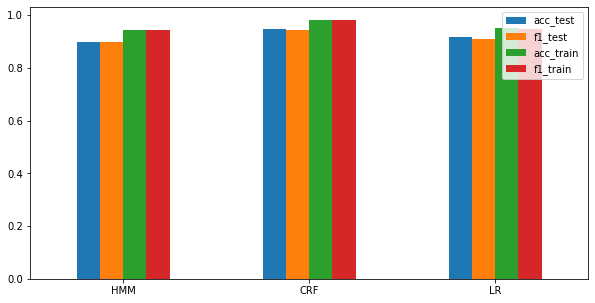

In [35]:
df_compare.plot(kind="bar", figsize=(10,5), rot=0)